# Info

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification

# Libraries Import

In [ ]:
import glob
import cv2
import tqdm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

In [ ]:
import os
from collections import Counter
import random
import re
import json
import pickle

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, Concatenate
from tensorflow.keras.layers import AvgPool2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from tensorflow.keras.applications import ResNet50

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from concurrent.futures import ThreadPoolExecutor

# Constants

In [ ]:
IMG_W = 224
IMG_H = 224

EPOCHS = 50
BATCH_SIZE = 32

VAL_SPLIT = 0.2

BASE_DIR = r'/content/drive/MyDrive/sketch_to_rgb'
# BASE_DIR = ''

# Functions

In [ ]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

# Dataset

In [ ]:
import kagglehub

# Download latest version
path_tom_jerry = kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification")
print("Path to dataset files:", path_tom_jerry)
print(os.listdir(path_tom_jerry))

Path to dataset files: /kaggle/input/tom-and-jerry-image-classification
['tom_and_jerry', 'challenges.csv', 'ground_truth.csv']


# Dataset Read

In [ ]:
def walk_inside_folder(folder_path):
  EXTENSIONS = ['png', 'jpeg', 'jpg']

  images_paths = []
  for root,dirs,files in os.walk(folder_path):
    for ext in EXTENSIONS:
      images_paths = images_paths + glob.glob(os.path.join(root,'*.'+ext))
  return images_paths


In [ ]:
images_paths = walk_inside_folder(path_tom_jerry)

# Exploration & Visualization

In [ ]:
print(f"Total images: {len(images_paths)}")

Total images: 5478


In [ ]:
for i in range(13):
    print(f"Image[{i:02d}] Shape:", cv2.imread(images_paths[i]).shape)

Image[00] Shape: (480, 854, 3)
Image[01] Shape: (480, 854, 3)
Image[02] Shape: (480, 854, 3)
Image[03] Shape: (480, 854, 3)
Image[04] Shape: (480, 854, 3)
Image[05] Shape: (720, 1280, 3)
Image[06] Shape: (480, 854, 3)
Image[07] Shape: (480, 854, 3)
Image[08] Shape: (480, 854, 3)
Image[09] Shape: (480, 854, 3)
Image[10] Shape: (480, 854, 3)
Image[11] Shape: (480, 854, 3)
Image[12] Shape: (480, 854, 3)


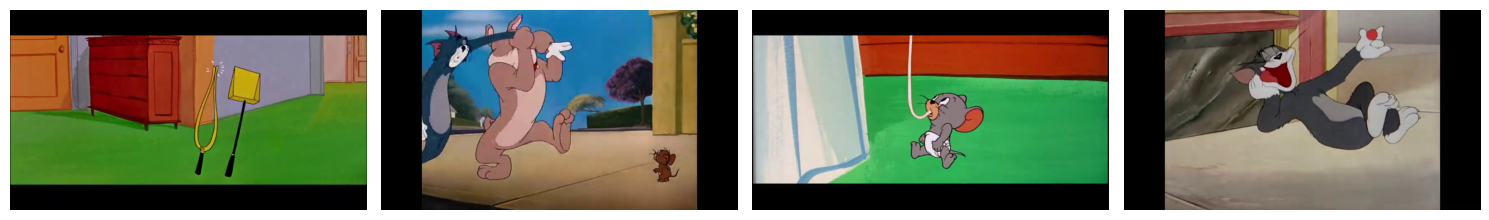

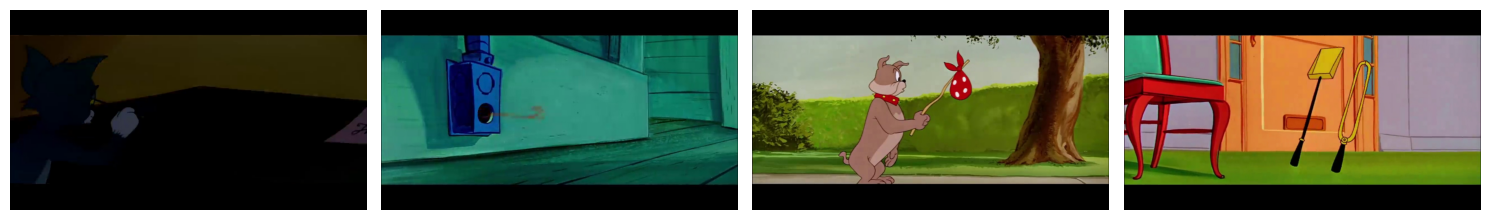

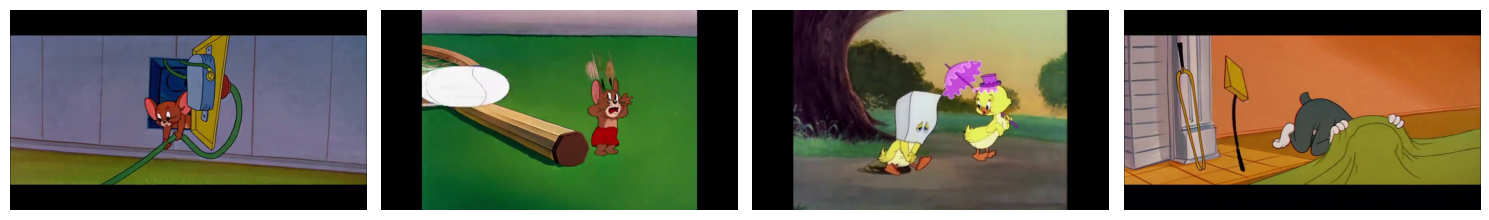

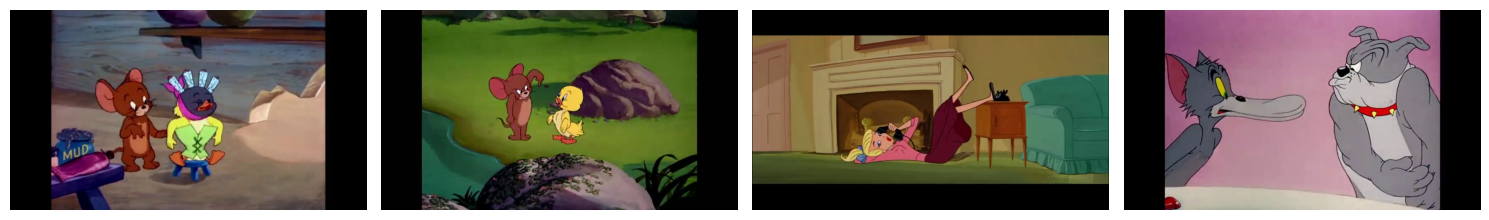

In [ ]:
N_ROWS = 4
N_COLS = 4

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, N_COLS, figsize=(15, 15))

    for j in range(N_COLS):
            id_j = np.random.randint(0, len(images_paths))
            img_path_i = images_paths[id_j]
            img_i = cv2.imread(img_path_i, 1)
            img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)

            axs[j].imshow(img_i, cmap='gray')
            axs[j].axis('off')

    fig.tight_layout()
    plt.show()

# Images Preprocessing

Blur Filters

In [ ]:
# make image smooth
def apply_filter_gaussian(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma).astype(image.dtype)

# remove salt and pepper noise
def apply_filter_median(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size).astype(image.dtype)

# preserve edges while reducing noise
def apply_filter_bilateral(image, d=9, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space).astype(image.dtype)

In [ ]:
def apply_gradient_magnitude(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(grad_x ** 2 + grad_y ** 2)

    mag_norm = cv2.normalize(mag, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) * 255

    return mag_norm.astype(image.dtype)

def apply_gradient_direction(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    direction = np.arctan2(grad_y, grad_x)

    direction_norm = (direction + np.pi) / (2 * np.pi) * 255

    return direction_norm.astype(image.dtype)

Edge Detection

In [ ]:
def apply_laplacian(image, ksize=3):
    return cv2.Laplacian(image, cv2.CV_32F, ksize=ksize).astype(image.dtype)

def apply_sobel(image, dx=1, dy=0, ksize=3):
    return cv2.Sobel(image, cv2.CV_32F, dx, dy, ksize=ksize).astype(image.dtype)

def apply_canny(image, threshold1=100, threshold2=150):
    return cv2.Canny(image, threshold1, threshold2).astype(image.dtype)

Kmeans

In [ ]:
def apply_kmeans(image, n_colors = 12):
    n_channels = image.shape[2] if len(image.shape) == 3 else 1

    Z = image.reshape((-1, n_channels)).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, label, center = cv2.kmeans(Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]

    clustered = res.reshape(image.shape)
    return clustered

In [ ]:
def preprocess_image_from_path(image_path):
    image = cv2.imread(image_path, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (IMG_H, IMG_W))

    image = apply_kmeans(image)
    grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edge = apply_canny(grey_image)

    edge = np.expand_dims(edge, axis=-1)

    image = (image / 255.0).astype(np.float32)
    edge = (edge / 255.0).astype(np.float32)

    return [image, edge]

(224, 224, 3) (224, 224, 1)


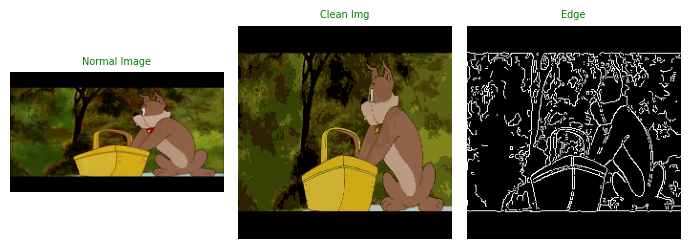

(224, 224, 3) (224, 224, 1)


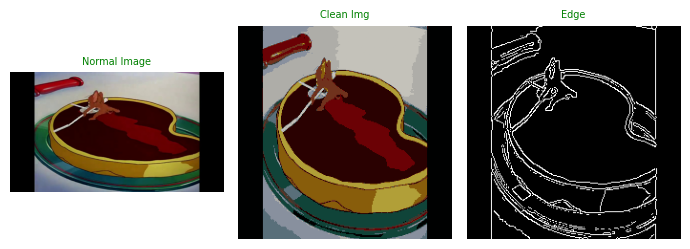

(224, 224, 3) (224, 224, 1)


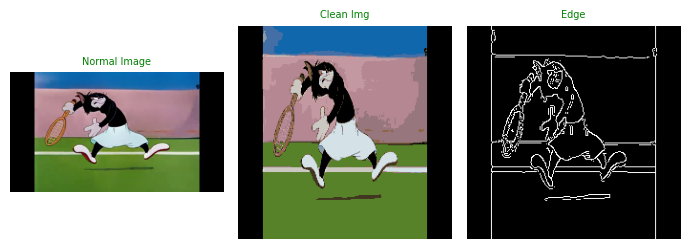

(224, 224, 3) (224, 224, 1)


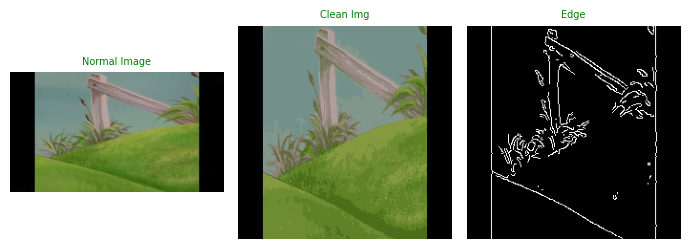

(224, 224, 3) (224, 224, 1)


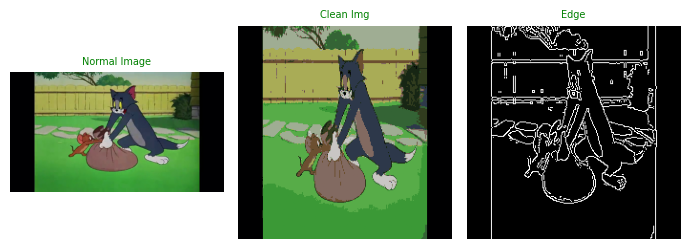

In [ ]:
N_ROWS = 5
IMG_SHAPE = None

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, 3, figsize=(7, 7))
    id_j = np.random.randint(0, len(images_paths))
    img_path_i = images_paths[id_j]

    img_i = cv2.imread(img_path_i, 1)
    img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)
    img_i_processed, edge_img = preprocess_image_from_path(img_path_i)

    print(img_i_processed.shape, edge_img.shape)

    axs[0].imshow(img_i.squeeze(), cmap='gray')
    axs[0].set_title(f"Normal Image", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(img_i_processed, cmap='gray')
    axs[1].set_title(f"Clean Img", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(edge_img, cmap='gray')
    axs[2].set_title(f"Edge", fontsize=7, color='green')
    axs[2].axis('off')

    IMG_SHAPE = img_i_processed.shape

    fig.tight_layout()
    plt.show()

# Data Split

In [ ]:
threshold = VAL_SPLIT * len(images_paths)

np.random.shuffle(images_paths)
images_paths_train = images_paths[:-int(threshold)]
images_paths_val = images_paths[-int(threshold):]

In [ ]:
print(f"Train images: {len(images_paths_train)}")
print(f"Val images: {len(images_paths_val)}")

Train images: 4383
Val images: 1095


# Data Augmentation

In [ ]:
def custom_augmentation_numpy(image, edge_img):
    # -----------------------------
    # 1. Random Horizontal Flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        edge_img = np.fliplr(edge_img)

    # -----------------------------
    # 2. Random Vertical Flip
    # if np.random.rand() > 0.5:
    #     image = np.flipud(image)
    #     edge_img = np.flipud(edge_img)

    # -----------------------------
    # 3. Random Rotation (-15 to 15 degrees)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-15, 15)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)
        edge_img = cv2.warpAffine(edge_img, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)

    # -----------------------------
    # 4. Random Crop and Resize Back
    if np.random.rand() > 0.5:
        h, w = image.shape[:2]
        crop_scale = np.random.uniform(0.9, 1.0)
        new_h, new_w = int(h * crop_scale), int(w * crop_scale)
        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)
        image = image[top:top + new_h, left:left + new_w]
        edge_img = edge_img[top:top + new_h, left:left + new_w]
        image = cv2.resize(image, (w, h))
        edge_img = cv2.resize(edge_img, (w, h), interpolation=cv2.INTER_NEAREST)

    # -----------------------------
    # 5. Random Brightness (image only)
    if np.random.rand() > 0.5:
        brightness_shift = np.random.uniform(-0.05, 0.05)
        image = image + brightness_shift
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 6. Random Contrast (image only)
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.8, 1.2)
        mean = image.mean(axis=(0, 1), keepdims=True)
        image = (image - mean) * factor + mean
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 7. Random Gaussian Noise (image only)
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.025, image.shape)
        image = image + noise
        image = np.clip(image, 0, 1)

    return image, edge_img


In [ ]:
class MyDataGenerator(Sequence):
    def __init__(self, images_paths, batch_size=32, augment=True, shuffle=True, n_workers=4):
        self.images_paths = np.array(images_paths)
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers
        self.on_epoch_end()

        # Runtime cache
        self._image_cache = dict()

    def __len__(self):
        return int(np.ceil(len(self.images_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images_paths = self.images_paths[batch_x]

        batch_images_edge_pairs_paths = self._load_images_parallel(batch_images_paths)

        if self.augment:
            batch_images_edge_pairs = [custom_augmentation_numpy(*img) for img in batch_images_edge_pairs_paths]

        return [x[1] for x in batch_images_edge_pairs], [x[0] for x in batch_images_edge_pairs]

    def on_epoch_end(self):
        self.indices = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_images_parallel(self, paths):
        with ThreadPoolExecutor(max_workers=self.n_workers) as executor:
            image_edge_pairs = list(executor.map(self._load_and_preprocess_single, paths))
        return image_edge_pairs

    def _load_and_preprocess_single(self, path):
        if path in self._image_cache:
            return self._image_cache[path]
        else:
            image_edge_pair = preprocess_image_from_path(path)
            self._image_cache[path] = image_edge_pair
            return self._image_cache[path]


In [ ]:
train_generator = MyDataGenerator(images_paths_train, batch_size=BATCH_SIZE, augment=True, shuffle=True)
val_generator = MyDataGenerator(images_paths_val, batch_size=BATCH_SIZE, augment=False, shuffle=False)

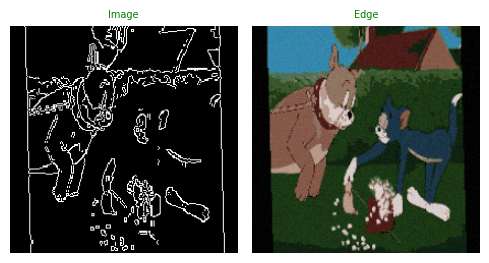

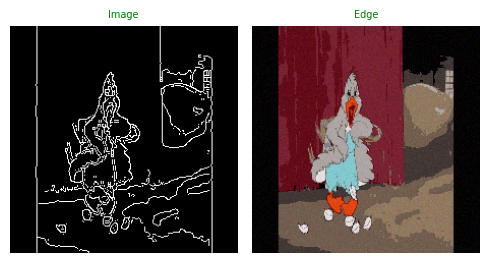

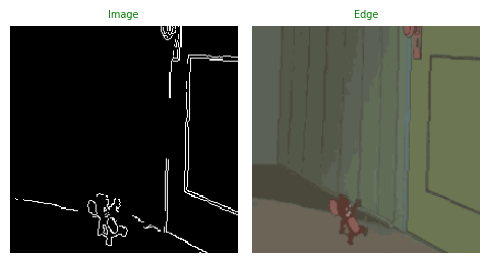

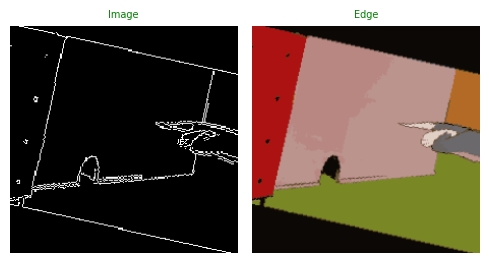

In [ ]:
random_batch_x,random_batch_y  = train_generator[0]

for i in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(5,5))
    axs[0].imshow(random_batch_x[i], cmap='gray')
    axs[0].set_title(f"Image", fontsize=7, color='green')
    axs[0].axis('off')
    axs[1].imshow(random_batch_y[i], cmap='gray')
    axs[1].set_title(f"Edge", fontsize=7, color='green')
    axs[1].axis('off')

    fig.tight_layout()
    plt.show()

# Model Encapsulation

In [ ]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR, 'models_cache')
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [ ]:
class HistoryCheckpoint(Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.filepath = os.path.join(CACHE_MODELS_DIR_NAME, f'{model_name}.history.json')
        self.history = {}

        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as f:
                self.history = json.load(f)
                print(F'Model {self.model_name} history loaded from cache')
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(float(value))

        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)

    def get_history(self):
        return self.history

In [ ]:
class CustomModel:
    def __init__(self, name, model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()
        self.model = model

        self.y_train_hat = None
        self.y_val_hat = None
        self.y_test_hat = None

        self._history = {}

        self.load()

    def fit(self, data_gen, validation_data, epochs, batch_size, force_train= False, class_weights=None):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'

        es = EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1,
            restore_best_weights=True
        )

        mcp = ModelCheckpoint(
            filepath=file_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            mode='min',
            verbose=1
        )

        rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

        hcp = HistoryCheckpoint(self.name)

        if self.trained == False or force_train:
            history_callback = self.model.fit(data_gen,
                           validation_data = validation_data,
                           callbacks=[es, mcp, rop, hcp],
                           epochs = epochs,
                           batch_size = batch_size,
                           class_weight=class_weights)
            self.trained = True
            self._history = hcp.get_history() # Store history from callback
        else:
             self._history = hcp.get_history() # Load history from cache if not training


    @property
    def history(self):
        return self._history


    def prdict_on_train(self, x_train):
        if self.y_train_hat is None:
            self.y_train_hat = self.model.predict(x_train)
        return self.y_train_hat

    def prdict_on_val(self, x_val):
        if self.y_val_hat is None:
            self.y_val_hat = self.model.predict(x_val)
        return self.y_val_hat

    def prdict_on_test(self, x_test):
        if self.y_test_hat is None:
            self.y_test_hat = self.model.predict(x_test)
        return self.y_test_hat

    def save(self):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'
        self.model.save_weights(file_path)

    def load(self):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'

        if os.path.exists(file_path):
            self.model.load_weights(file_path)
            self.trained = True
            print(F'Model {self.name} weights loaded from cache')
        else:
            self.trained = False

# Models Arch

In [ ]:
models_list = list()

In [ ]:
def build_model_1():
    global models_list
    NAME = 'unet_1_simple_model'

    inputs = Input((IMG_H, IMG_W, 1))

    # Encoder
    c1 = Conv2D(32, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(32, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(64, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)


    # Bottleneck
    b = Conv2D(128, (3, 3), padding='same')(p2)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    b = Conv2D(128, (3, 3), padding='same')(b)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)

    # Decoder

    u3 = UpSampling2D((2, 2))(b)
    u3 = Conv2D(64, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = concatenate([u3, c2])
    c7 = Conv2D(64, (3, 3), padding='same')(u3)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(64, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u4 = UpSampling2D((2, 2))(c7)
    u4 = Conv2D(32, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = concatenate([u4, c1])
    c8 = Conv2D(32, (3, 3), padding='same')(u4)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Conv2D(32, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    outputs = Conv2D(3, (1,1), activation='sigmoid') (c8)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer='adam', loss='rms')

    model.summary()

    custom_model =  CustomModel(NAME, model)
    models_list = list(filter(lambda x: x.name != custom_model.name, models_list))
    models_list.append(custom_model)

build_model_1()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_4[0][0]  

 Total params: 520,673 (1.99 MB)

 Trainable params: 519,201 (1.98 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
for model in models_list:
    if isinstance(model.model, tf.keras.Model):
        try:
          keras_model = model.model

          img_path = os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_arch.png')

          plot_model(
              keras_model,
              to_file= img_path,
              show_shapes=True,
              dpi =200,
              show_layer_names=True,
              expand_nested=True,
              show_layer_activations=True,
              show_trainable=True,
              show_dtype=True,
          )
        except:
          pass

# Model Training

In [ ]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")
    model.fit(train_generator,val_generator, epochs= 50, batch_size= BATCH_SIZE, force_train=False)
    print('\n')

1. Train: simple_cnn_v01


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1752945044.478780     109 service.cc:148] XLA service 0x7d98680027a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752945044.480533     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752945044.480556     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752945045.163315     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/18 ━━━━━━━━━━━━━━━━━━━━ 3:05 11s/step - accuracy: 0.1250 - loss: 1.9315

I0000 00:00:1752945049.667969     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2724 - loss: 1.8483
Epoch 1: val_loss improved from inf to 1.84819, saving model to models_cache/simple_cnn_v01.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.2760 - loss: 1.8431 - val_accuracy: 0.2336 - val_loss: 1.8482 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.4387 - loss: 1.4313
Epoch 2: val_loss did not improve from 1.84819
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 487ms/step - accuracy: 0.4369 - loss: 1.4316 - val_accuracy: 0.2263 - val_loss: 1.8492 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.4713 - loss: 1.3857
Epoch 3: val_loss improved from 1.84819 to 1.79320, saving model to models_cache/simple_cnn_v01.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 508ms/step - accuracy: 0.4727 - loss: 1.3810 - val_accuracy: 0.2336 - val_loss: 1.7932 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.5581 - loss:

# History

In [ ]:
plt.style.use(plt.style.available[9])

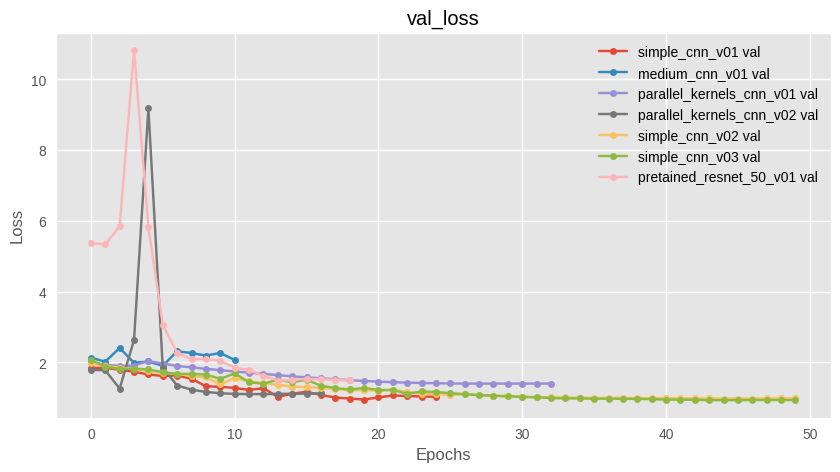

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.title("val_loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')

for idx, model in enumerate(models_list):
    plt.plot(model.history['val_loss'], linestyle='-', marker='o', markersize=5,
            label=f'{model.name} val')

plt.legend()
plt.show()

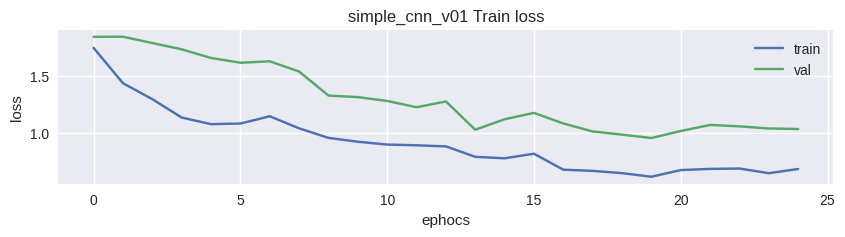

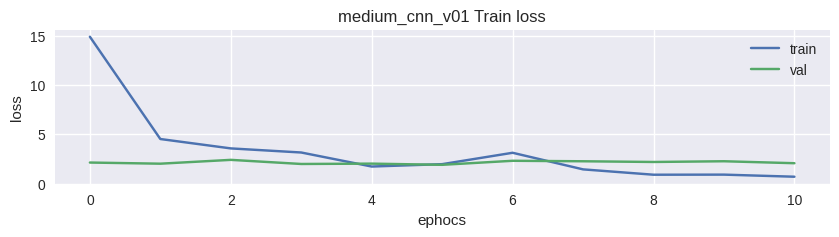

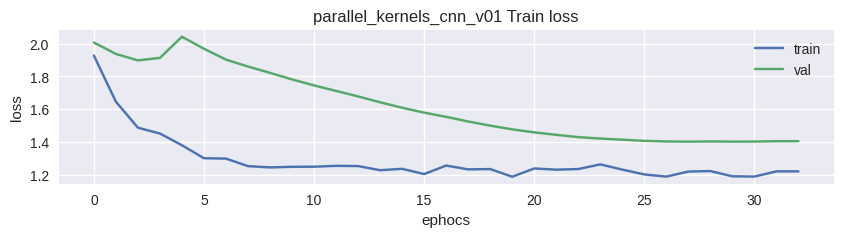

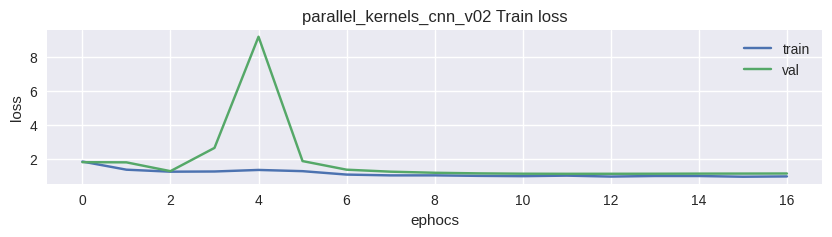

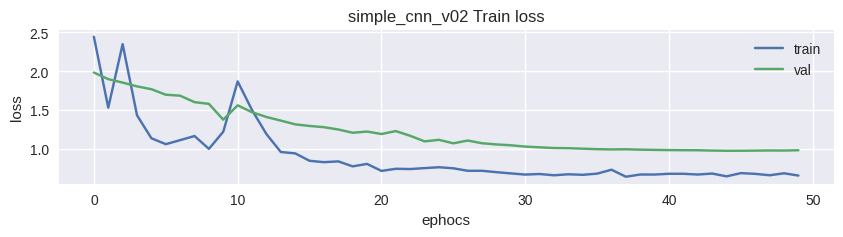

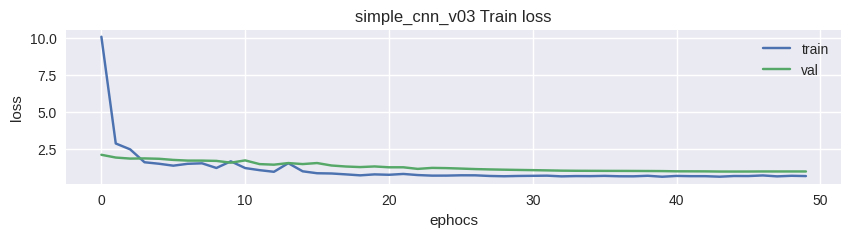

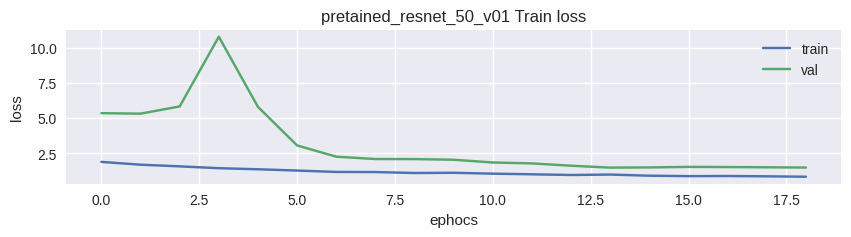

In [ ]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))
    plt.grid(True)
    plt.title(f"{model.name} Train loss")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['loss'], label='train')
    plt.plot(model.history['val_loss'], label='val')
    plt.legend()
    plt.show()

# Model Eval

# Depolyment